# Mail Spam classifier using NLP    
**Requirements: You will need to have NLTK installed, along with downloading the corpus for stopwords.**

In [1]:
# ONLY RUN THIS CELL IF YOU NEED 
# TO DOWNLOAD NLTK AND HAVE CONDA

# Uncomment the code below and run:

# !conda install nltk #This installs nltk
#import nltk # Imports the library
#nltk.download() #Download the necessary datasets

## Get the Data

I'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)! This dataset is already located in the smsspamcollection folder.

The file I am using contains a collection of more than 5 thousand SMS phone messages. You can check out the **readme** file for more info.

In [2]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
print(len(messages))

5574


## View Data Sample

In [3]:
for message_number, message in enumerate(messages[:5]):
    print(message_number, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though




Due to the spacing we can tell that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. (Note our numbers aren't part of the file, they are just from the **enumerate** call).

Using these labeled ham and spam examples, I'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, I'll be able to **classify arbitrary unlabeled messages** as ham or spam.

Instead of parsing TSV manually using Python, we can just take advantage of pandas! Let's go ahead and import it!

In [4]:
import pandas as pd

In [5]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [6]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [7]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's make a new column to detect how long the text messages are:

In [8]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization
Let's visualize this! Let's do the imports:

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')

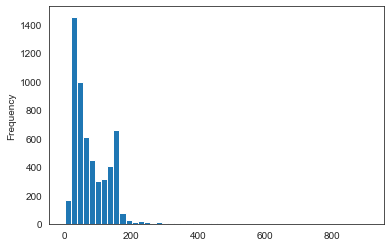

In [10]:
messages['length'].plot(bins=50, kind='hist') 

In [11]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

**Trying to see if message length is a distinguishing feature between ham and spam:**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FAED2FDCC8>,
      dtype=object)

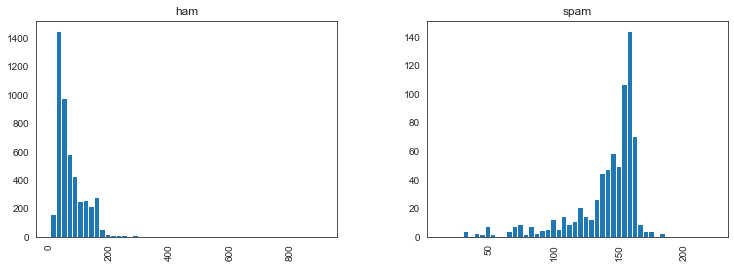

In [12]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

Now let's begin to process the data so we can eventually use it with SciKit Learn!

## Text Pre-processing

There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

I'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. I'll also remove very common words, ('the', 'a', etc..). To do this I will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. I'll only use some of the basic ones here.

For removing punctuation. I will take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

In [13]:
from nltk.corpus import stopwords

In [14]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

## Vectorization

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

I'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  I will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
import string

In [16]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages.

After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

To transform the entire bag-of-words corpus into TF-IDF corpus at once:

## Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572). 

## Creating a Data Pipeline

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

## Training model

In [21]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001FAED3495E8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

## Model Evaluation

In [27]:
predictions = pipeline.predict(msg_test)

In [28]:
from sklearn.metrics import classification_report 
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98       996
        spam       0.75      1.00      0.86       119

    accuracy                           0.96      1115
   macro avg       0.87      0.98      0.92      1115
weighted avg       0.97      0.96      0.97      1115



# Thanks!